In [9]:
using LinearAlgebra, Plots, SparseArrays
using PolynomialRoots, ProgressBars

In [7]:
function pade_run_time(r, M, Δx, Δt)

    # gives the coefficients to the 2*kth derivative for 2*r+1 point formalism.
    function get_coeff_2kth_derviative(r,k=1)
        A = [2*i^(2*j)//factorial(2*j) for i=1:r, j=1:r]
        B = hcat(rotr90(Matrix(1I, r, r)), [-2 for i=1:r], Matrix(1I, r, r))
        coeff = inv(A)*B
        return Rational.(coeff[k,r+1:end])
    end

    # generate the matrix K from given potential
    # Ψ_{n+1} = K * Ψ_n
    function get_time_evolution_matrix(potential_vals; r=2, z_s = -2, Δt=Δt, Δx=Δx, mass=mass, ħ=ħ)

        b = (im * ħ * Δt) / (2 * mass * (Δx)^2)
        cn_coeffs = get_coeff_2kth_derviative(r)
        a_ks = (b / z_s) * cn_coeffs
        spatial_samples = length(potential_vals)
        d_js = (1 + a_ks[begin]) * ones(spatial_samples) - potential_vals * (im * Δt / ħ) / z_s


        I = [i for i = 1:spatial_samples]
        J = [j for j = 1:spatial_samples]
        S = d_js
        for k = 1:r
            upper_tri_i = [i for i = 1:spatial_samples-k]
            upper_tri_j = [i + k for i = 1:spatial_samples-k]

            I = vcat(I, upper_tri_i, upper_tri_j)
            J = vcat(J, upper_tri_j, upper_tri_i)

            S = vcat(S, a_ks[k+1] * ones(2 * (spatial_samples - k)))
        end

        A1 = Matrix(sparse(I, J, S))

        return inv(A1) * conj.(A1)
    end

    function pade_coeffs_exp(M)
        C = [1//factorial(i+j-1) for i in 1:M, j in 1:M]
        C_right = -[1//factorial(i+M) for i in 1:M]
        coeff = inv(C)*C_right
        b_rev = vcat(coeff,1)
        b = reverse(b_rev)    
    
        a = []
        s = +1
        for b_ in b
            a = vcat(a, s*b_)
            s = -s
        end
    
        return Rational.(a), b
    
    end
    
    function roots_pade_exp(M)
        a, b = pade_coeffs_exp(M)
        return roots(a), roots(b)
    end

    function get_pade_time_evolution_matrix(potential_vals; M=1, r = 3, Δt=Δt, Δx=Δx, mass=mass, ħ=ħ)
        K = 1I
        a_roots,_ = roots_pade_exp(M)
        for s in 1:M
            Ks = get_time_evolution_matrix(potential_vals; r=r, z_s = a_roots[s], Δt=Δt, Δx=Δx, mass=mass, ħ=ħ)
            K = K*Ks
        end
        return K
    end

    ħ = 1
    mass = 1/2
    
    x_vals = -50:Δx:50
    t_vals = 0:Δt:50

    # Initialize the wavefunction
    Ψ_vals = (x -> exp(-(x+20)^2/10 - im*5/ħ*x)).(x_vals)
    Ψ_vals = Ψ_vals / sqrt(sum(Ψ_vals .* conj.(Ψ_vals)))

    potential_vals = (x -> 0).(x_vals)
    Ψ_grid = copy(Ψ_vals)

    K = get_pade_time_evolution_matrix(potential_vals; M=M, r=r, Δt=Δt, Δx=Δx, mass=mass, ħ=ħ)

    for t_i in 2:length(t_vals)
        Ψ_grid = hcat(Ψ_grid, K * Ψ_grid[:,t_i-1])
    end

end

pade_run_time (generic function with 1 method)

In [11]:
# [@btime pade_run_time(j, 3, 0.1, 0.1) for i in 1:5]
cpu_times = zeros(9,9)
for j in 1:9
    r = j
    for i in 1:9
        M = i
        cpu_times[i,j] = @elapsed pade_run_time(M, r, 0.1, 0.1)
    end
end


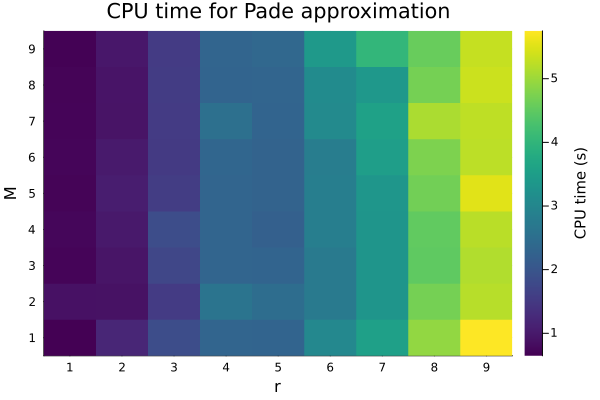

In [19]:
heatmap(cpu_times, title="CPU time for Pade approximation", xlabel="r", ylabel="M", yticks=1:9, xticks=1:9, color=:viridis,
    colorbar_title="CPU time (s)")

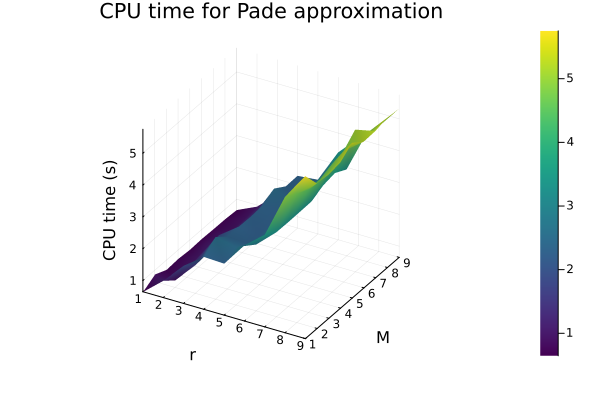

In [26]:
surface(cpu_times, title="CPU time for Pade approximation", xlabel="r", ylabel="M", zlabel="CPU time (s)", yticks=1:9, xticks=1:9, color=:viridis)